In [1]:
from IPython.display import Image, display
import numpy as np
import reddemcee
np.random.seed(1234)

# Evidence

We will start with a simple 2D gaussian shell evaluation:
- Widely used in the literature (vg, dynesty and multinest papers, as well as Vousden and Lartillot&Philippe 2009)
- It is analytically tractable.

## Constants
In the following section we will define the relevant constants to the problem, similarly to the Quickstart section.


In [2]:
ndim_ = 2  # n dimensions
r_ = 2.  # radius
w_ = 0.1  # width
hard_limit = 6  # hard search boundary

limits_ = [-hard_limit,  hard_limit]
c1_ = np.zeros(ndim_)
c1_[0] = -3.5
c2_ = np.zeros(ndim_)
c2_[0] = 3.5
const_ = np.log(1. / np.sqrt(2. * np.pi * w_**2))

In [3]:
def logcirc(theta, c):
    # log-likelihood of a single shell
    d = np.sqrt(np.sum((theta - c)**2, axis=-1))  # |theta - c|
    return const_ - (d - r_)**2 / (2. * w_**2)


def loglike(theta):
    # log-likelihood of two shells
    return np.logaddexp(logcirc(theta, c1_), logcirc(theta, c2_))


def logprior(theta):
    # prior for our parameters
    lp = 0.
    for i in range(ndim_):
        if  theta[i] <= limits_[0] or limits_[1] <= theta[i]:
            return -np.inf
    return lp

And some plot utilities to visualize our results:

In [4]:
def plot_betas_ratios(sampler, setup):
    bh = sampler.betas_history
    rh = sampler.ratios_history

    fig, axes = pl.subplots(2, 1, figsize=(9, 5), sharex=True)

    bh1 = bh.reshape((setup[2], setup[0]))
    rh1 = rh.reshape((setup[2], setup[0]-1))

    for i in range(setup[0]-2):
            bh_sel = bh1[:, i]
            b = 1/np.array(bh_sel)
            axes[0].plot(np.arange(setup[2])*setup[3], b)
            axes[0].set_xscale('log')
            axes[0].set_yscale('log')


    for i in np.arange(setup[0]-1):
        r = rh1[:, i]
        axes[1].plot(np.arange(setup[2])*setup[3], r, alpha=0.5)

    if True:
        axes[1].set_xlabel("N Step")
        axes[0].set_ylabel(r"$\beta^{-1}$")
        axes[1].set_ylabel(r"$a_{frac}$")

    pl.tight_layout()
    


### Setup
Here we write the sampler initial conditions:
Since we are doing thermodynamic integration, we will ramp up the temperatures to 10:

In [147]:
setup = [20, 100, 3500, 2]
ntemps, nwalkers, nsweeps, nsteps = setup
p0 = list(np.random.uniform(limits_[0], limits_[1], [ntemps, nwalkers, ndim_]))

### Initiating the sampler

In [148]:
sampler = reddemcee.PTSampler(nwalkers, ndim_, loglike, logprior,
                              ntemps=ntemps,
                              adaptative=True,
                              config_adaptation_halflife=500,
                              config_adaptation_rate=0.3,
                              config_adaptation_decay=0)
    
silent = sampler.run_mcmc(p0, nsweeps, nsteps, progress=True)

100%|████████████████████████████████████████████████████████████████| 7000/7000 [04:55<00:00, 23.70it/s]


## Retrieving Results

We can examine how the temperatures behaved, and we see by eye they stabilized at around 200 samples. Nevertheless, the ratios converge a bit later, at around ~300 samples.

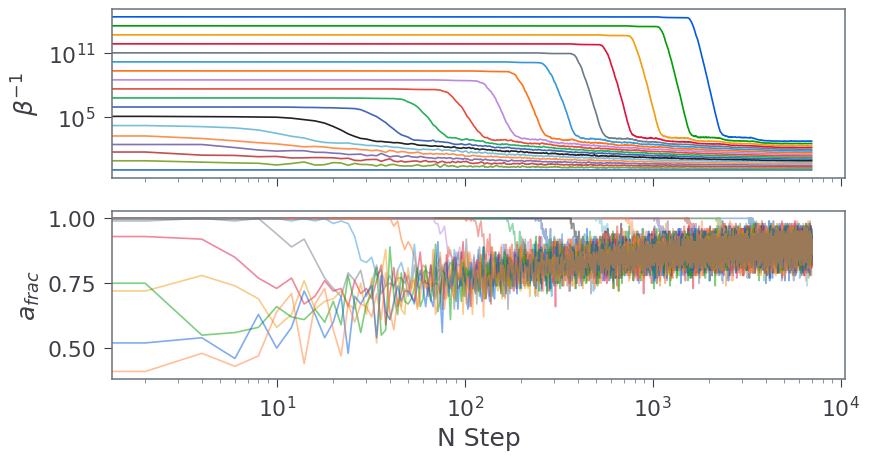

In [149]:
plot_betas_ratios(sampler, setup)

#### The Evidence
We can retrieve the results with the *thermodynamic_integration()* function. We discard the unstable samples with the keyword discard, for this showcase we will use the last 100 samples.
This function performs thermodynamic integration as described in the emperor paper (*link*), and returns (evidence, error, discretization error, sampling error), we are interested in the first two results.

You can also use *thermodynamic_integration_classic()* to compare with (*Vousden's implementation*).

For this problem the evidence is analitically tractable (see Lartillot&Phillipe 2009): 

$$Z = -1.75$$

In [150]:
Z, Zerr, Zerr_d, Zerr_s = sampler.thermodynamic_integration(discard=500)
Zc, Zcerr = sampler.thermodynamic_integration_classic(discard=500)

print(f'Evidence reddemcee: {np.round(Z,3)} +- {np.round(Zerr,3)}')
print(f'Evidence classic  : {np.round(Zc,3)} +- {np.round(Zcerr,3)}')

Evidence reddemcee: -2.85 +- 0.072
Evidence classic  : -2.922 +- 0.218


A very accurate result considering the length of the chain! Furthermore, we can take a peek at how the temperatures adapted during the run (horizontal color lines) and where they ended (solid circles). The shaded area corresponds to the classic integration method, which gives some insight on what is being calculated:

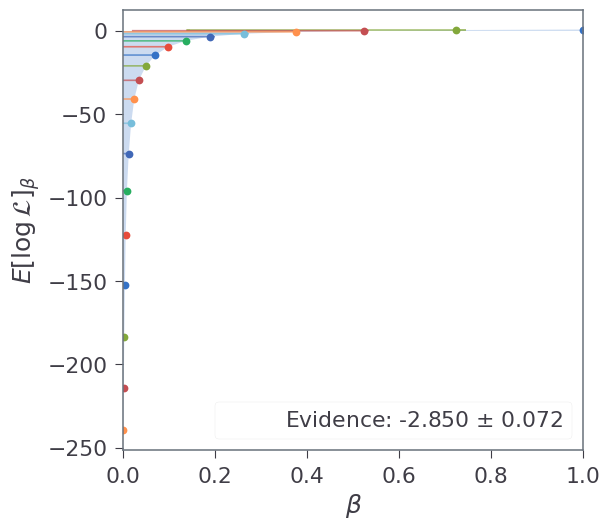

In [151]:
likes = sampler.get_logls(flat=True)    
betas = sampler.betas_history.reshape((setup[2], setup[0])).T

logls = np.array([np.mean(likes[t]) for t in range(setup[0])])
    
cor = ['C0', 'C1', 'C2', 'C4', 'C5', 'C7', 'C8', 'C9']
colors = np.array([cor,cor,cor,cor,cor]).flatten()

xaxis_la = r'$\beta$'
yaxis_la = r'$E[\log \mathcal{L}]_\beta$'
my_text = rf'Evidence: {Z:.3f} $\pm$ {Zerr:.3f}'
if True:
    fig, ax = pl.subplots()
    for ti in range(ntemps):
        bet = betas[ti]
        ax.plot(bet, np.ones_like(bet)*logls[ti], colors[ti], alpha=0.7)
        ax.plot(bet[-1], logls[ti], colors[ti]+'o')

    ylims = ax.get_ylim()
        
    betas0 = [x[-1] for x in betas]
    ax.fill_between(betas0, logls,
                        y2=0,
                        #color='w',
                        alpha=0.25)
        
    ax.set_ylim(ylims)
if True:
    ax.scatter([], [], alpha=0, label=my_text)
    pl.legend(loc=4)
    ax.set_xlabel(xaxis_la)
    ax.set_ylabel(yaxis_la)
        
    ax.set_xlim([0, 1])
    pl.tight_layout()


## Comparison of different schemes

1. vousden adapt
2. ppena adapt
3. linear
4. geometric

In [152]:
# linear
sampler_l = reddemcee.PTSampler(nwalkers, ndim_, loglike, logprior,
                              ntemps=ntemps,
                              adaptative=False,
                              betas=np.linspace(1, 0, ntemps))
    
samples_l = sampler_l.run_mcmc(p0, nsweeps, nsteps, progress=True)

100%|████████████████████████████████████████████████████████████████| 7000/7000 [05:01<00:00, 23.18it/s]


In [153]:
# geom
sampler_g = reddemcee.PTSampler(nwalkers, ndim_, loglike, logprior,
                              ntemps=ntemps,
                              adaptative=False)
    
samples_g = sampler_g.run_mcmc(p0, nsweeps, nsteps, progress=True)

100%|████████████████████████████████████████████████████████████████| 7000/7000 [04:56<00:00, 23.59it/s]


In [154]:
from scipy.interpolate import PchipInterpolator

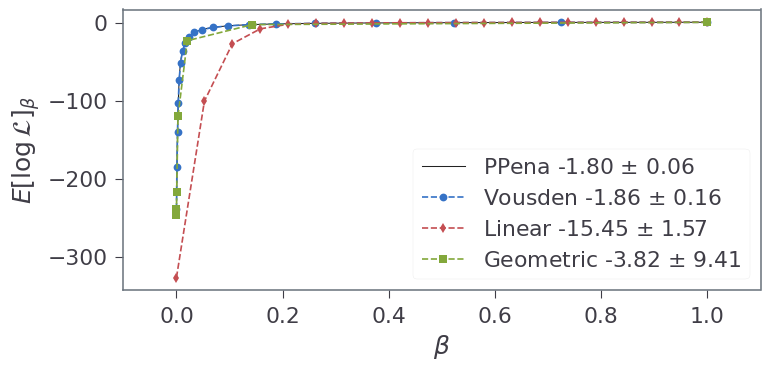

In [156]:
discard0 = 6200
# vousden = 'classic'
logls = np.mean(sampler.get_logls(flat=True, discard=discard0), axis=1)
Zc, Zcerr = sampler.thermodynamic_integration_classic(discard=discard0)
betas_v = sampler.betas
logls_v = logls

# ppena = ''
Z, Zerr, Zerr_d, Zerr_s = sampler.thermodynamic_integration(discard=discard0)

if True:
    x = sampler.betas[::-1]
    y = logls[::-1]
    num_grid = sampler.z_num_grid
    num_simulations = sampler.z_num_simulations
    xnew = np.linspace(min(x), max(x), num_grid)
    pchip = PchipInterpolator(x, y)
    ynew = pchip(xnew)

# linear
Zl, Zlerr = sampler_l.thermodynamic_integration_classic(discard=discard0)
betas_l = sampler_l.betas
logls_l = np.mean(sampler_l.get_logls(flat=True, discard=discard0), axis=1)
# geom
Zg, Zgerr = sampler_g.thermodynamic_integration_classic(discard=discard0)
betas_g = sampler_g.betas
logls_g = np.mean(sampler_g.get_logls(flat=True, discard=discard0), axis=1)


# plots
if True:
    fig, ax = pl.subplots(figsize=(8, 4))
    ax.plot(xnew, ynew, 'k-', label=rf'PPena {Z:.2f} $\pm$ {Zerr:.2f}', lw=0.75, alpha=1)
    ax.plot(betas_v, logls_v, 'bo--', label=rf'Vousden {Zc:.2f} $\pm$ {Zcerr:.2f}')
    ax.plot(betas_l, logls_l, 'rd--', label=rf'Linear {Zl:.2f} $\pm$ {Zlerr:.2f}')
    ax.plot(betas_g, logls_g, 'gs--', label=rf'Geometric {Zg:.2f} $\pm$ {Zgerr:.2f}')

if True:
    pl.legend(loc=4)
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'$E[\log \mathcal{L}]_\beta$')
        
    ax.set_xlim([-0.1, 1.1])
    pl.tight_layout()

pl.savefig('evidence.png')

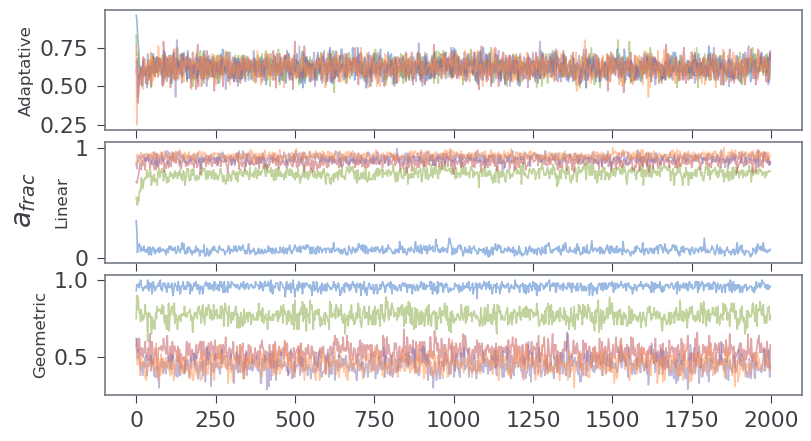

In [100]:
fig, axes = pl.subplots(3, 1, figsize=(9, 5), sharex=True)
pl.subplots_adjust(hspace=0.1)
rh = sampler.ratios_history
rh1 = rh.reshape((setup[2], setup[0]-1))
for i in range(setup[0]-1):
    r = rh1[:, i]
    axes[0].plot(np.arange(setup[2])*setup[3], r, alpha=0.5)
    
# linear
rh = sampler_l.ratios_history
rh1 = rh.reshape((setup[2], setup[0]-1))
for i in range(setup[0]-1):
    r = rh1[:, i]
    axes[1].plot(np.arange(setup[2])*setup[3], r, alpha=0.5)

# geometric
rh = sampler_g.ratios_history
rh1 = rh.reshape((setup[2], setup[0]-1))
for i in range(setup[0]-1):
    r = rh1[:, i]
    axes[2].plot(np.arange(setup[2])*setup[3], r, alpha=0.5)

axes[0].set_ylabel("Adaptative", fontsize=12)
axes[1].set_ylabel("Linear", fontsize=12)
axes[2].set_ylabel("Geometric", fontsize=12)
fig.supylabel(r"$a_{frac}$")
#fig.supxlabel("N step")

#pl.tight_layout()
pl.savefig('asd.png')

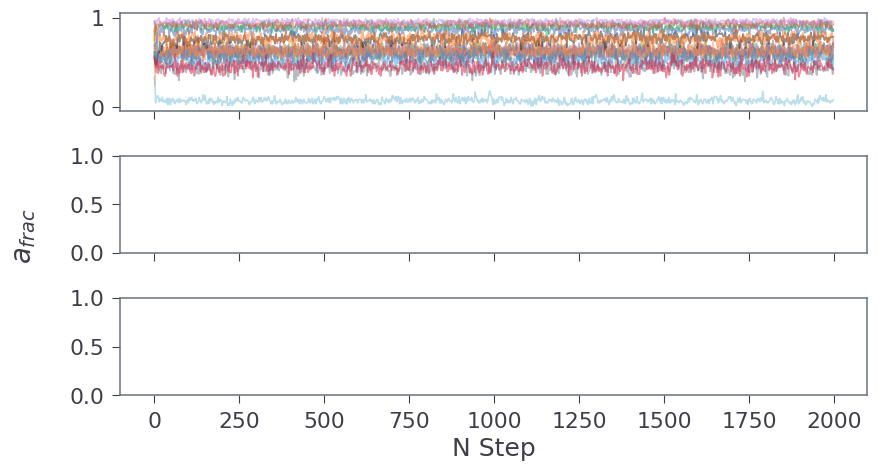

In [78]:
plot_ratios([sampler, sampler_l, sampler_g])

In [76]:
sampler_l.ratios_history

array([0.34, 0.55, 0.69, ..., 0.87, 0.85, 0.93])